# **Tell Me What You Want, I'll Tell You What You Like**

In this file, we try to use the first clustering approach (the basic version) (random exploration)

## DOcplex Python API installation

First, we install the docplex python API which we will use for modelling our problem and solving it. (Then, we will not have problem size error)

In [1]:
import sys
try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        !pip install docplex -q
        print("!pip install docplex -q...")
    else:
        !pip install --user docplex -q
        print("!pip install --user docplex -q...")
        
print("End of the intallation of python API...")

End of the intallation of python API...


## Main code

In [2]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
import time

In [3]:
#############################
### Essentials functions ###
#############################
import clustering as cl
sys.path.append("..")
import FunctionMain as fm
from Solver import *
from User import *

In [4]:
# ----------------- Parameters

# The file to consider
file = '../file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 10

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300

# Number of iteration stop criterion
it_max = 20

# The number of solutions that we will have in the solver after the first iteration
k_k = 10

# List of different search type (for the solver)
list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]

In [5]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []

# --------- Get essential information from the file
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, tasks = fm.initialize_solver(data, n, m, duration)

model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 4319
Le max de list_obj est 5508
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x7fc2bdf246c0>, <docplex.cp.solution.CpoSolveResult object at 0x7fc2f1b5c840>, <docplex.cp.solution.CpoSolveResult object at 0x7fc2bf926640>], [], [<docplex.cp.solution.CpoSolveResult object at 0x7fc2b34a9640>, <docplex.

In [6]:
####################################################################
#### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
####################################################################


###  -------------- Iteration of the solver with the preferences

# Initialization of the counter of iteration
it = 1
# Initialization of the counter of time
tps = runtime
# Initialization of the list of the objective function (that we would like to plot later)
list_min_obj = [min(list_obj)]
# Initialization of the list of the objective function globally (that we would like to plot later)
list_min_obj_global = [min(list_obj)]

# Initialization of the stop criterion
criterion = (tps < tps_max) and (it < it_max) 

# ----------------- The loop for the problem (until a stop criterion is reached)
while criterion :
    print("\n--------Iteration {}---------".format(it))

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, tasks = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # --------- Add the constraints considering the clustering
    if it > 1:
        model, variables = solver.create_constraints(model, n, m, list_min_obj_global[it-1], T_machine)
    else :
        model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)
    
    #------------------ Layers creation 
    # layers = cl.create_layers(list_equal, matrix)
    layers = cl.create_layers_fixed(list_layers)
    
    # Get the list of number of clusters for each layer
    nb_clusters = fm.choose_best_clusters(layers)

    # The default value of the radius of the clusters if there is only one solution in the layer
    default_value_rayon = 5 

    # Iterating on layers
    for l in range(len(layers)):
        data = layers[l]
        k = nb_clusters[l]

        print("-------------- Layer", l, "-----------------")

        if l > 0:
            #------------------ If there is no solution in the layer, we skip this layer we add a constraint to the model
            if(len(data)==0):
                continue
            #------------------ If there is only one solution in the layer, we add a constraint to the model
            elif (len(data) == 1):
                solver.add_constraint(model, fm.manhattan_distance(data[0], [model.start_of(variables[i//m][i%m]) for i in range(n*m)]) > default_value_rayon + l)
                continue
            else :
            #------------------ Get the average of each cluster
                k, avg, labels = fm.average_computation(data, k)

            #------------------ Get the solutions which is the closest to the average of each cluster
                the_ones = fm.solution_average(k, data, labels, avg)
                
            #------------------ Add constraints: solutions must be distant from cluster centers, in each layer, by a distance greater than the cluster radius + l
                #------------------ List of layer l cluster solutions
                for i in range(k):
                    sol_cluster=[]
                    for j in range(len(data)):
                        if labels[j]==i:
                            sol_cluster.append(data[j])
                #------------------ Adding constraints
                    solver.add_constraint(model, fm.manhattan_distance(the_ones[i],[ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >  fm.rayon_cluster(the_ones[i], sol_cluster) + l)
            

    # ------------ Solve the model
    print("\nSolving the model...")
    # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)
    print("The number of solutions generated is :",nb_solution)

    # Adding the objective value of each solution to a list
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)+user.objectiveFunctionRegularity(sol, n, m))

    # ------------ Adding the min of objective function among the solutions generated to 
    # the list of objective function (for later display)
    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ------------ Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    # ------------ Adding the min of objective function among all solutions generated to 
    # the list of objective function (for later display)
    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)


#------------------ Stop criterion ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max)
    fm.stopCondition(it, it_max, tps, tps_max)

    it += 1


--------Iteration 1---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Clustering ...
5
-------------- Layer 0 -----------------
Number of clusters : 2
Number of solutions : 3
-------------- Layer 1 -----------------
Number of clusters : 0
Number of solutions : 0
-------------- Layer 2 -----------------
Number of clusters : 3
Number of solutions : 5
-------------- Layer 3 -----------------
Number of clusters : 1
Number of solutions : 1
-------------- Layer 4 -----------------
Number of clusters : 1
Number of solutions : 1

Solving the model...
The number of solutions generated is : 11599
Objective function : [4319, 4093]
Model solved !

Classing solutions...
Le min de list_obj est 4093
Le max de list_obj est 5508
Solutions classed !

Creating preferences...
Preferences created !
Il y a

[4319, 4093, 3935, 3886, 6151, 4387, 4006, 3906]


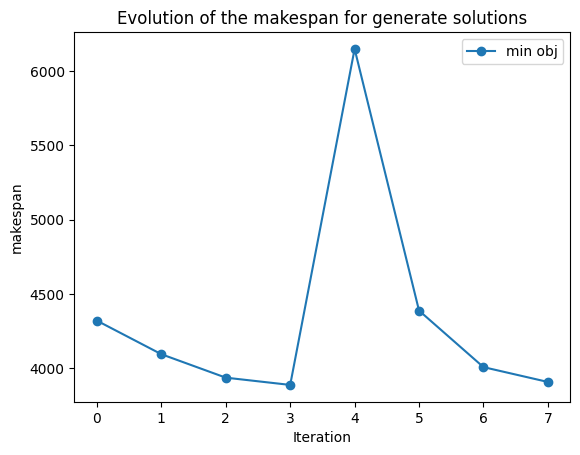

In [7]:
# Plot the minimum objective among the solutions generated

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[4319, 4093, 3935, 3886, 3886, 3886, 3886, 3886]


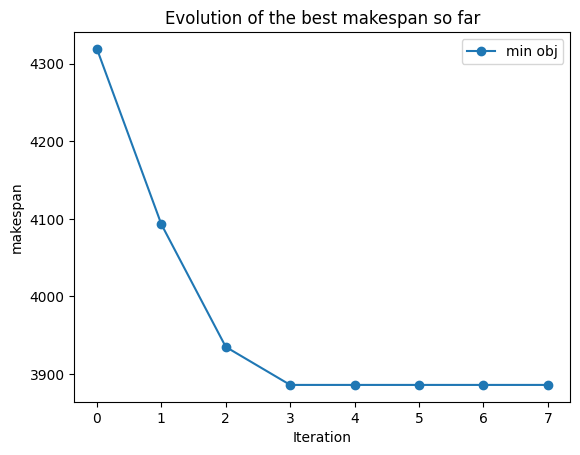

In [8]:
# Plot the minimum objective among all the solutions generated so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

In [9]:
# import main_ca as ca
# list_min_obj, list_min_obj_global = ca.main_ca('../file_with_optimal_val/la04.txt', "test0", 5, 20, 15, 100, 10, "plus")

80


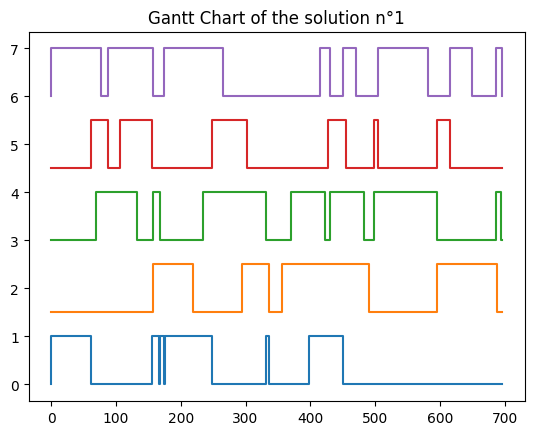

Makespan of the solution n°1 : 696
Regularity of the solution n°1 : 3190
Objective function of the solution n°1 : 2220240


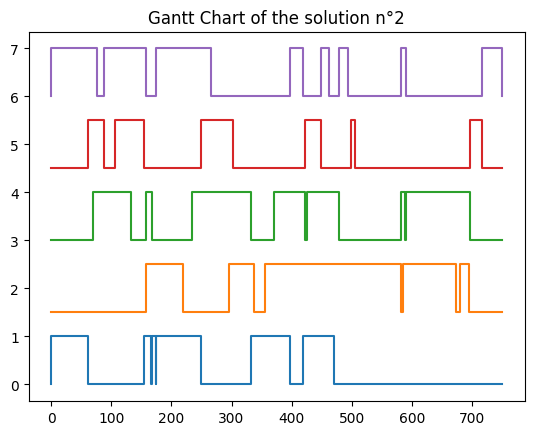

Makespan of the solution n°2 : 750
Regularity of the solution n°2 : 3156
Objective function of the solution n°2 : 2367000


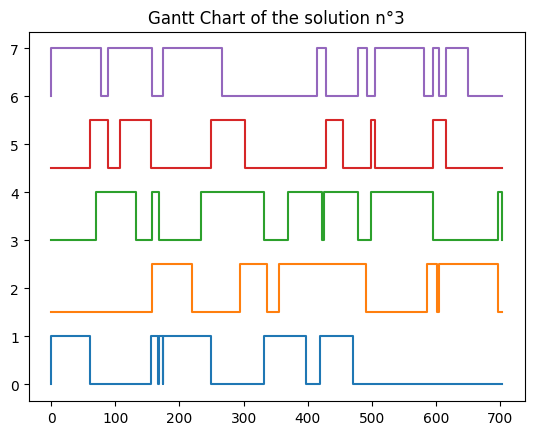

Makespan of the solution n°3 : 703
Regularity of the solution n°3 : 3226
Objective function of the solution n°3 : 2267878


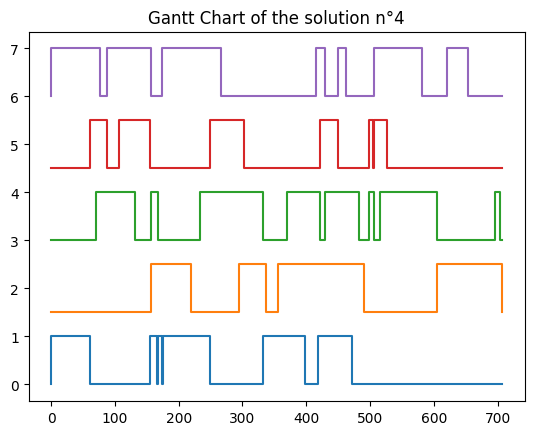

Makespan of the solution n°4 : 707
Regularity of the solution n°4 : 3228
Objective function of the solution n°4 : 2282196


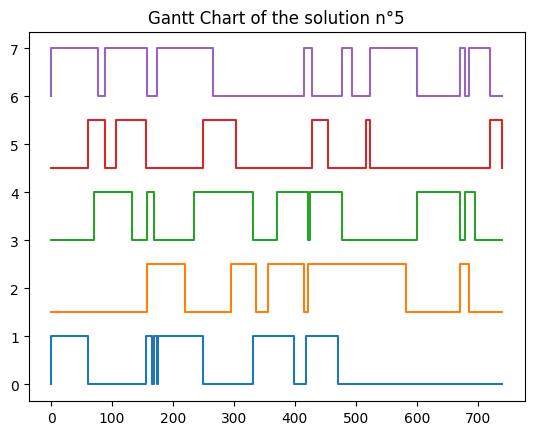

Makespan of the solution n°5 : 740
Regularity of the solution n°5 : 3266
Objective function of the solution n°5 : 2416840


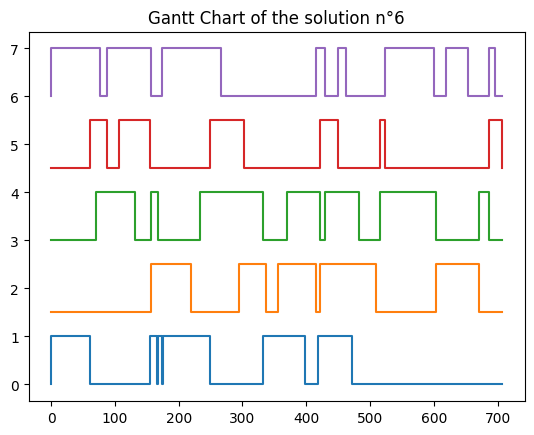

Makespan of the solution n°6 : 707
Regularity of the solution n°6 : 3302
Objective function of the solution n°6 : 2334514


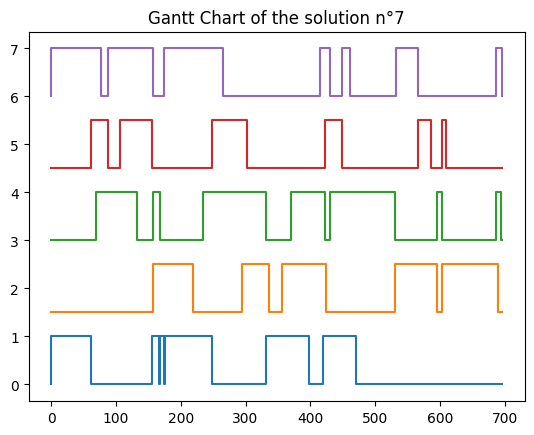

Makespan of the solution n°7 : 696
Regularity of the solution n°7 : 3320
Objective function of the solution n°7 : 2310720


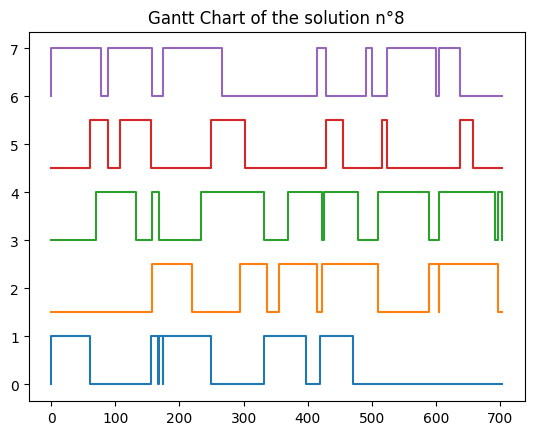

Makespan of the solution n°8 : 703
Regularity of the solution n°8 : 3346
Objective function of the solution n°8 : 2352238


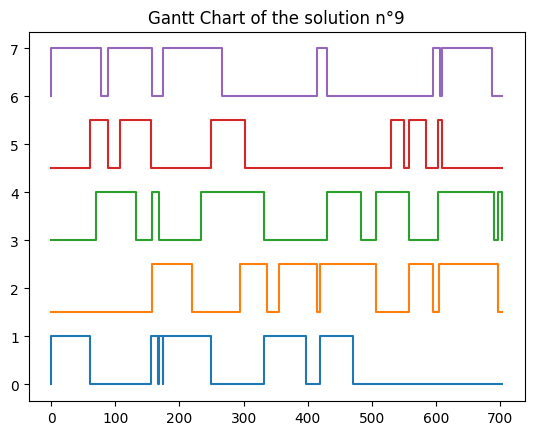

Makespan of the solution n°9 : 703
Regularity of the solution n°9 : 3390
Objective function of the solution n°9 : 2383170


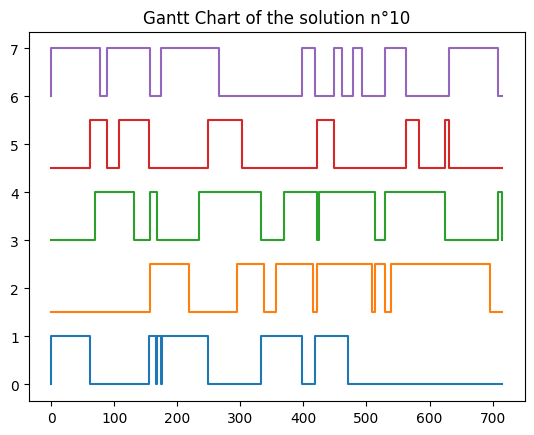

Makespan of the solution n°10 : 715
Regularity of the solution n°10 : 3386
Objective function of the solution n°10 : 2420990


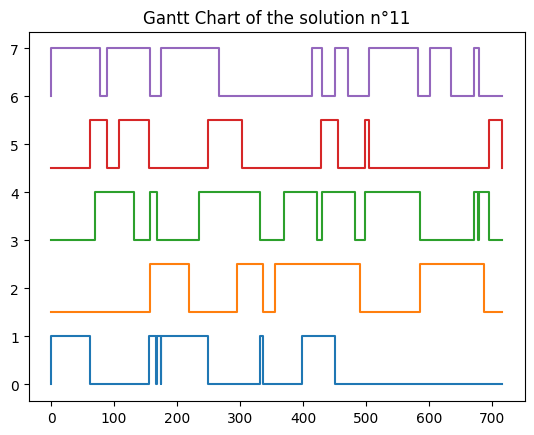

Makespan of the solution n°11 : 716
Regularity of the solution n°11 : 3390
Objective function of the solution n°11 : 2427240


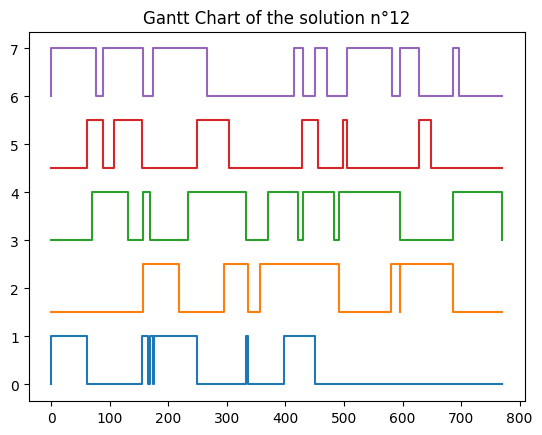

Makespan of the solution n°12 : 770
Regularity of the solution n°12 : 3348
Objective function of the solution n°12 : 2577960


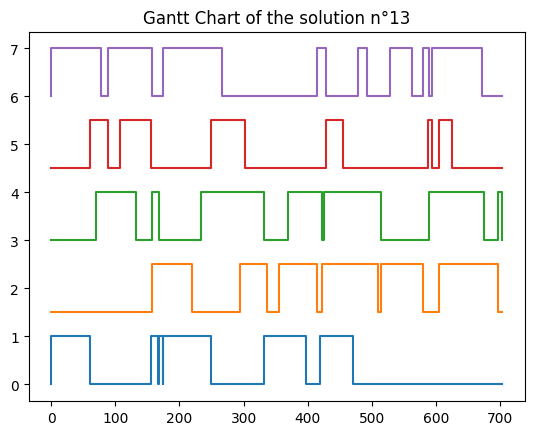

Makespan of the solution n°13 : 703
Regularity of the solution n°13 : 3424
Objective function of the solution n°13 : 2407072


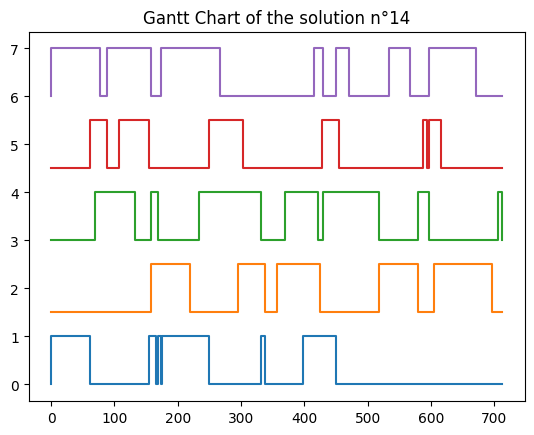

Makespan of the solution n°14 : 712
Regularity of the solution n°14 : 3416
Objective function of the solution n°14 : 2432192


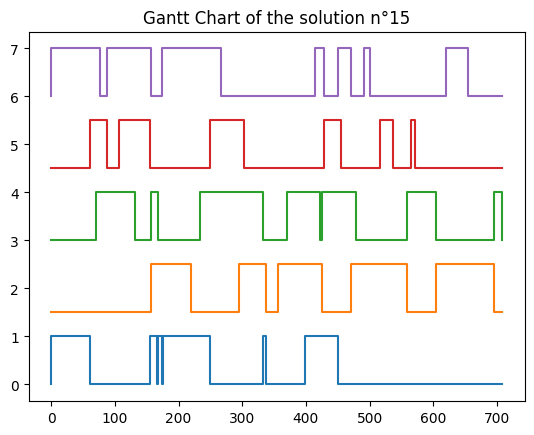

Makespan of the solution n°15 : 708
Regularity of the solution n°15 : 3478
Objective function of the solution n°15 : 2462424


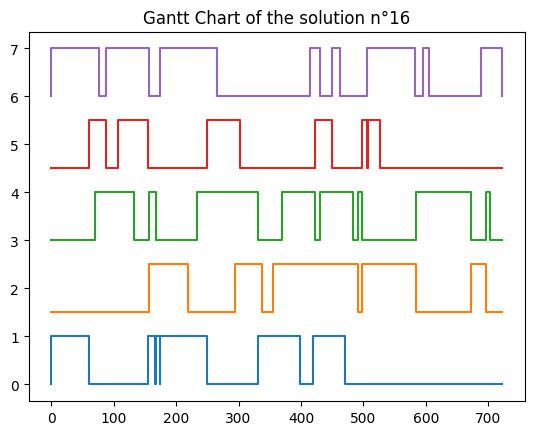

Makespan of the solution n°16 : 722
Regularity of the solution n°16 : 3500
Objective function of the solution n°16 : 2527000


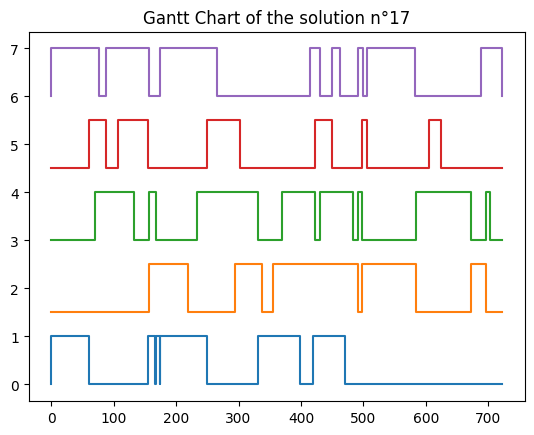

Makespan of the solution n°17 : 722
Regularity of the solution n°17 : 3500
Objective function of the solution n°17 : 2527000


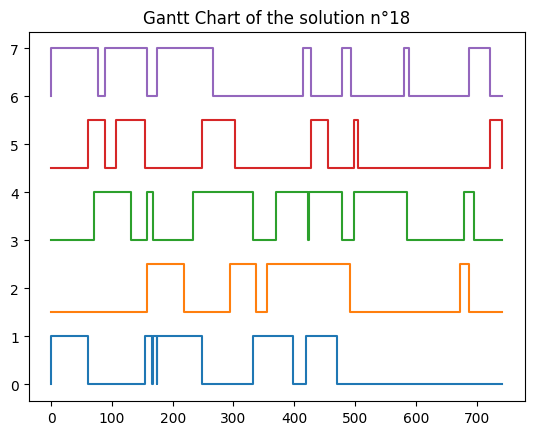

Makespan of the solution n°18 : 742
Regularity of the solution n°18 : 3530
Objective function of the solution n°18 : 2619260


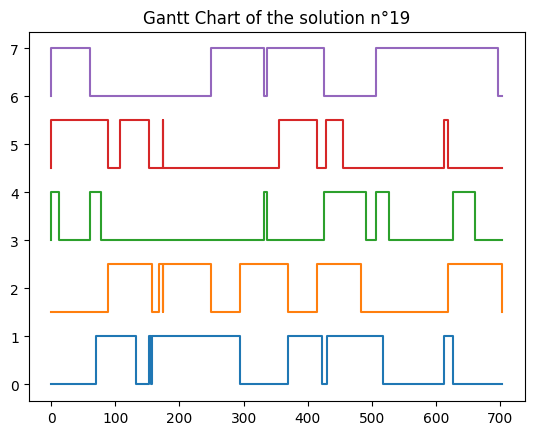

Makespan of the solution n°19 : 703
Regularity of the solution n°19 : 3616
Objective function of the solution n°19 : 2542048


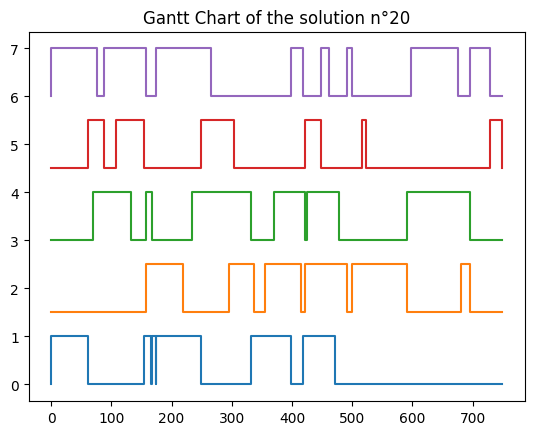

Makespan of the solution n°20 : 749
Regularity of the solution n°20 : 3596
Objective function of the solution n°20 : 2693404


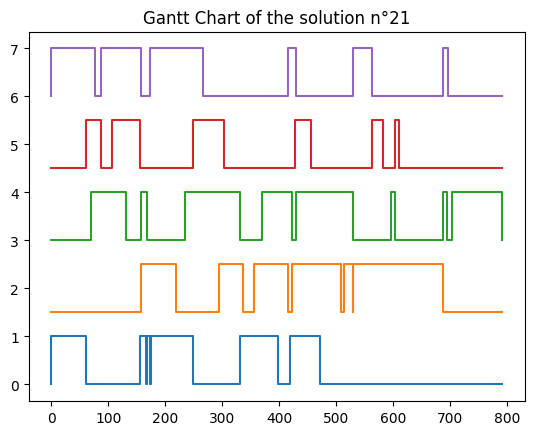

Makespan of the solution n°21 : 791
Regularity of the solution n°21 : 3568
Objective function of the solution n°21 : 2822288


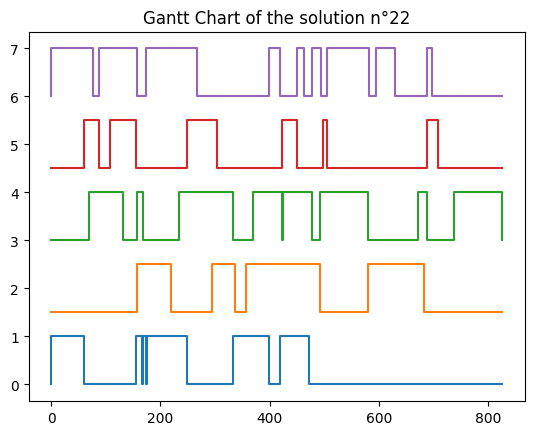

Makespan of the solution n°22 : 825
Regularity of the solution n°22 : 3562
Objective function of the solution n°22 : 2938650


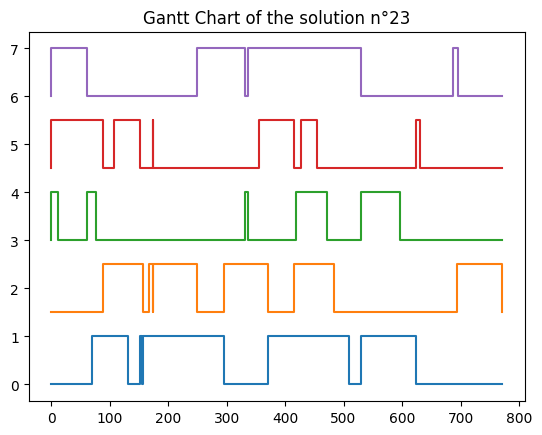

Makespan of the solution n°23 : 771
Regularity of the solution n°23 : 3624
Objective function of the solution n°23 : 2794104


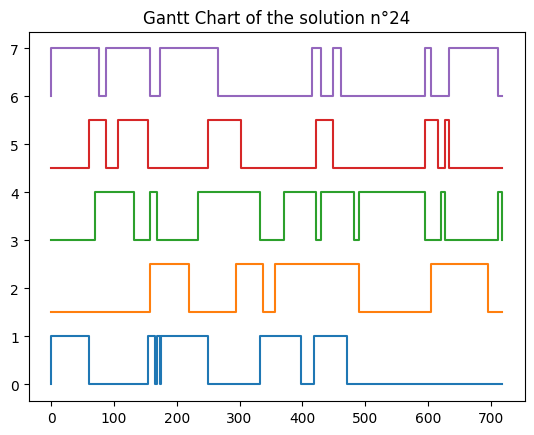

Makespan of the solution n°24 : 718
Regularity of the solution n°24 : 3694
Objective function of the solution n°24 : 2652292


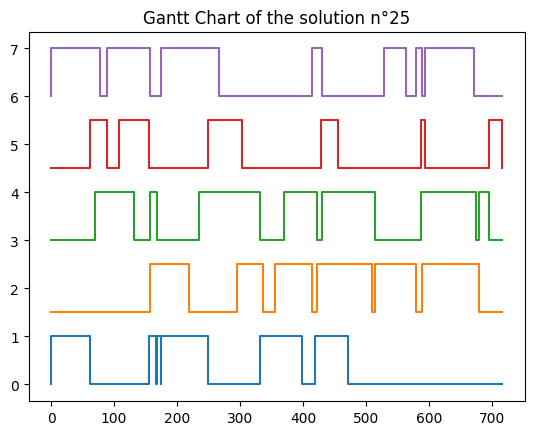

Makespan of the solution n°25 : 716
Regularity of the solution n°25 : 3724
Objective function of the solution n°25 : 2666384


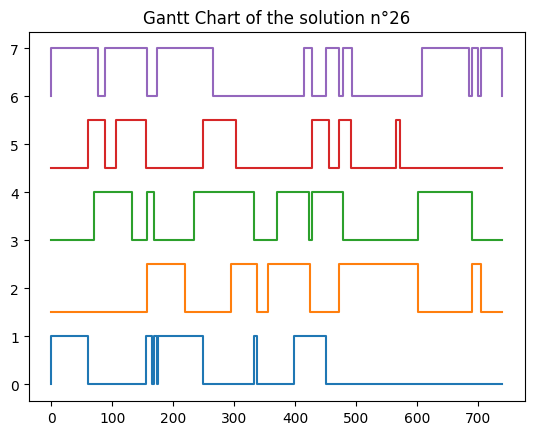

Makespan of the solution n°26 : 739
Regularity of the solution n°26 : 3746
Objective function of the solution n°26 : 2768294


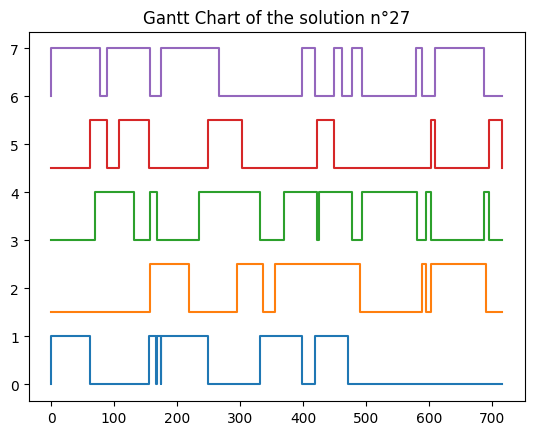

Makespan of the solution n°27 : 716
Regularity of the solution n°27 : 3868
Objective function of the solution n°27 : 2769488


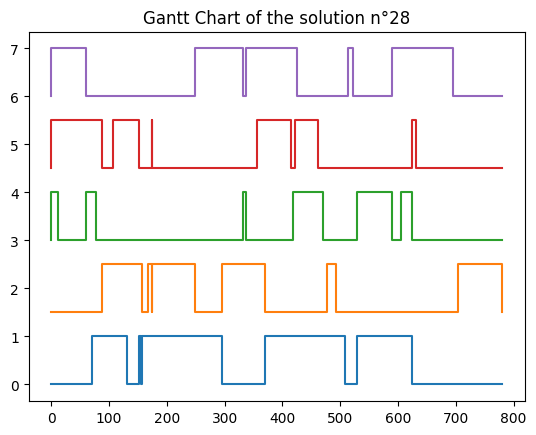

Makespan of the solution n°28 : 780
Regularity of the solution n°28 : 3814
Objective function of the solution n°28 : 2974920


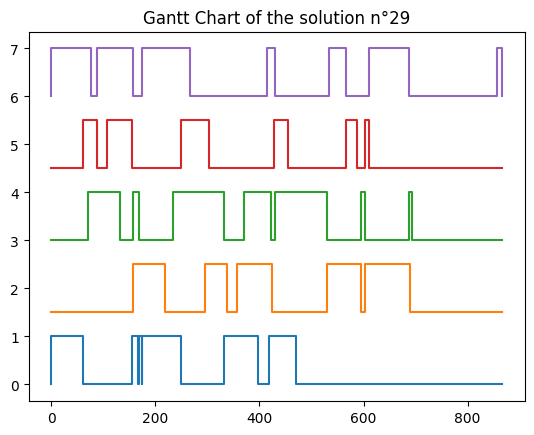

Makespan of the solution n°29 : 866
Regularity of the solution n°29 : 3818
Objective function of the solution n°29 : 3306388


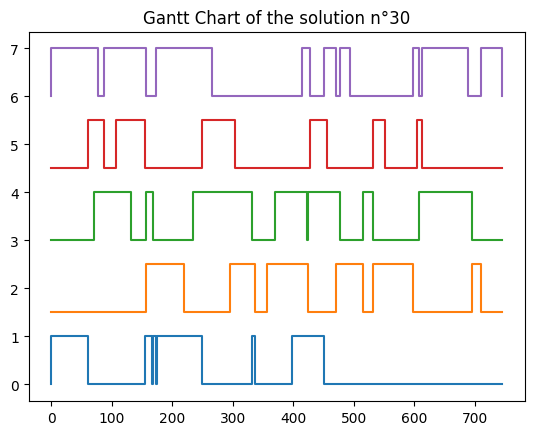

Makespan of the solution n°30 : 745
Regularity of the solution n°30 : 3946
Objective function of the solution n°30 : 2939770


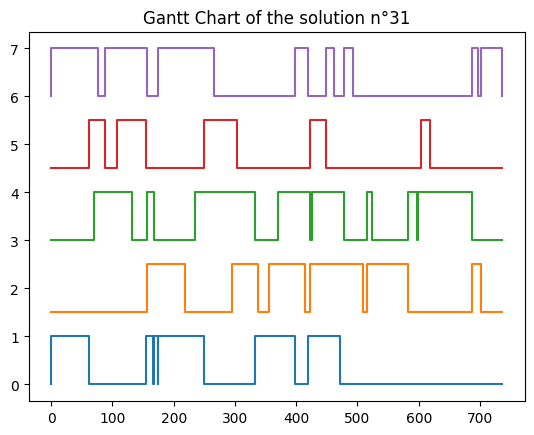

Makespan of the solution n°31 : 736
Regularity of the solution n°31 : 3976
Objective function of the solution n°31 : 2926336


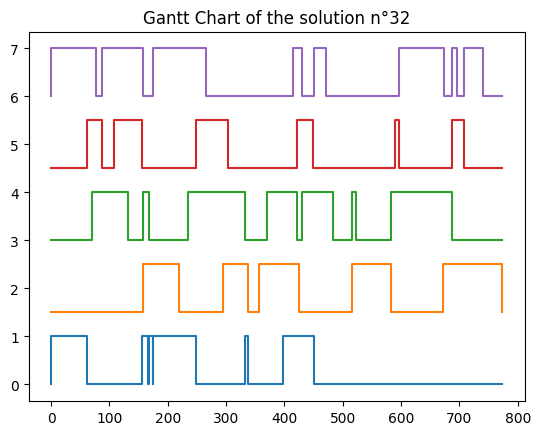

Makespan of the solution n°32 : 773
Regularity of the solution n°32 : 3962
Objective function of the solution n°32 : 3062626


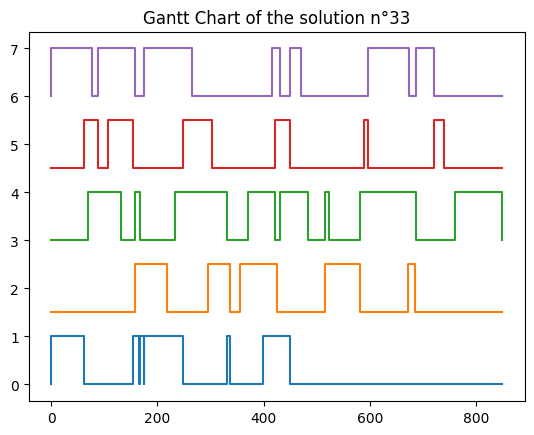

Makespan of the solution n°33 : 849
Regularity of the solution n°33 : 4050
Objective function of the solution n°33 : 3438450


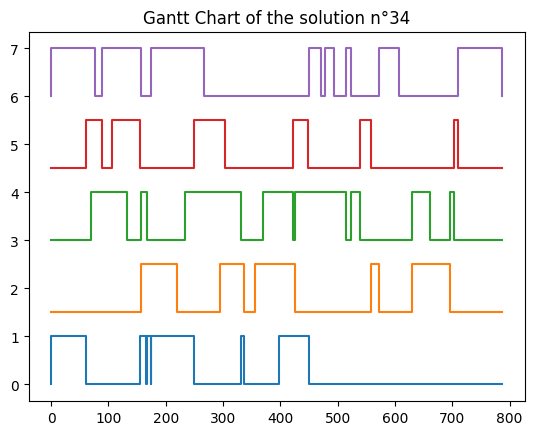

Makespan of the solution n°34 : 787
Regularity of the solution n°34 : 4154
Objective function of the solution n°34 : 3269198


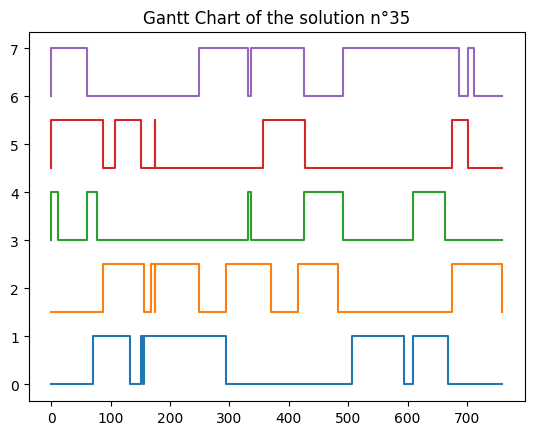

Makespan of the solution n°35 : 759
Regularity of the solution n°35 : 4258
Objective function of the solution n°35 : 3231822


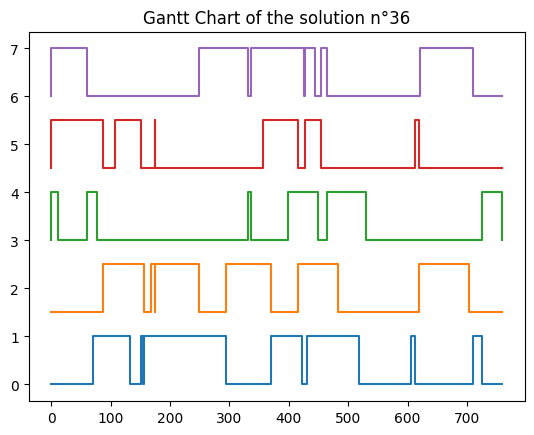

Makespan of the solution n°36 : 759
Regularity of the solution n°36 : 4262
Objective function of the solution n°36 : 3234858


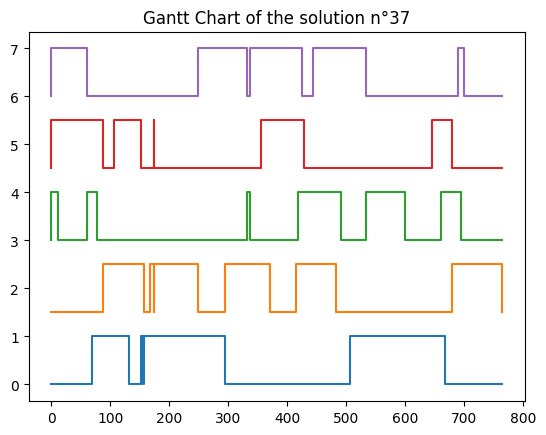

Makespan of the solution n°37 : 764
Regularity of the solution n°37 : 4294
Objective function of the solution n°37 : 3280616


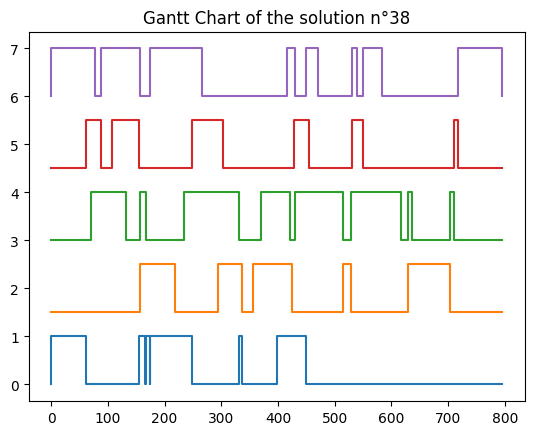

Makespan of the solution n°38 : 795
Regularity of the solution n°38 : 4274
Objective function of the solution n°38 : 3397830


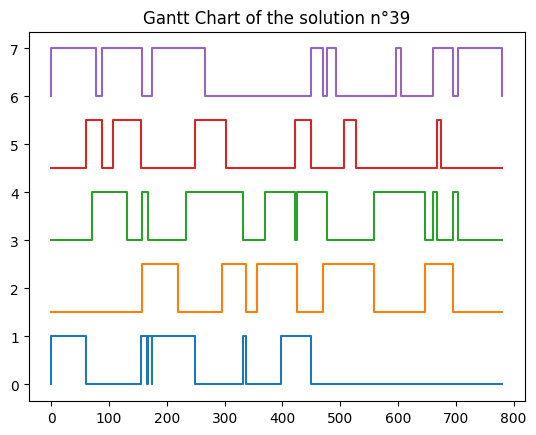

Makespan of the solution n°39 : 780
Regularity of the solution n°39 : 4318
Objective function of the solution n°39 : 3368040


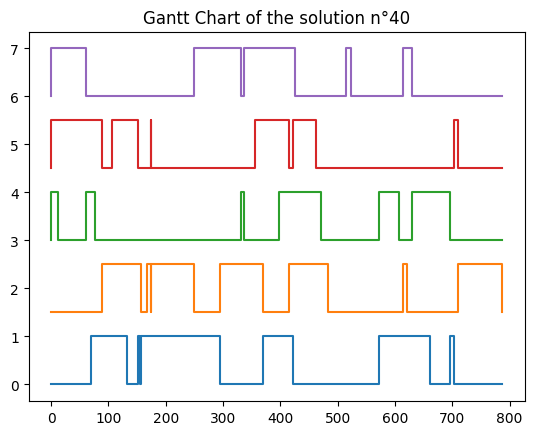

Makespan of the solution n°40 : 787
Regularity of the solution n°40 : 4326
Objective function of the solution n°40 : 3404562


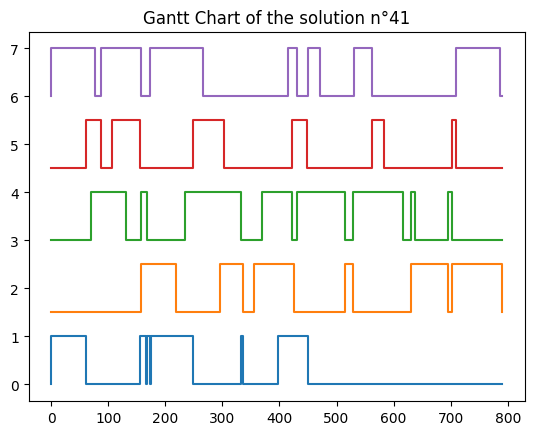

Makespan of the solution n°41 : 790
Regularity of the solution n°41 : 4342
Objective function of the solution n°41 : 3430180


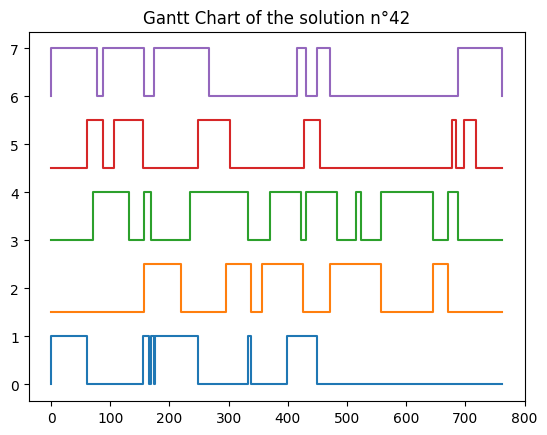

Makespan of the solution n°42 : 762
Regularity of the solution n°42 : 4392
Objective function of the solution n°42 : 3346704


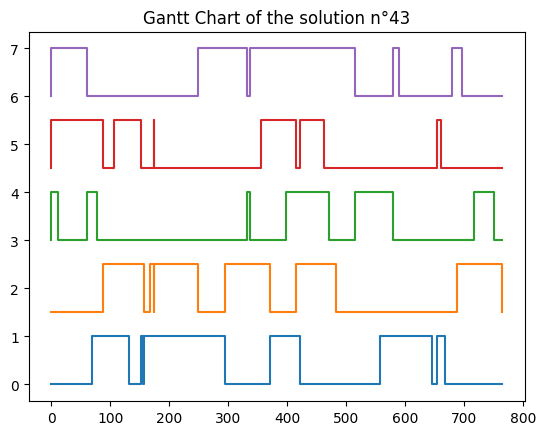

Makespan of the solution n°43 : 764
Regularity of the solution n°43 : 4414
Objective function of the solution n°43 : 3372296


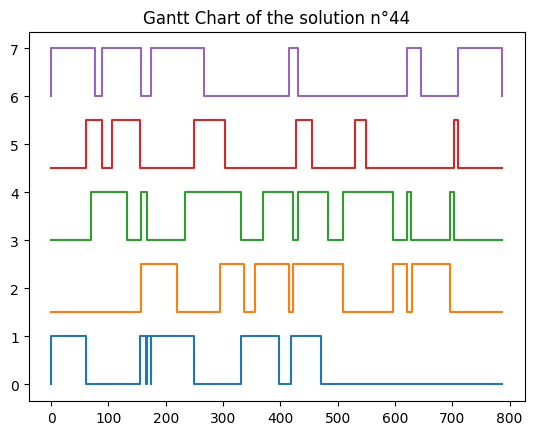

Makespan of the solution n°44 : 787
Regularity of the solution n°44 : 4426
Objective function of the solution n°44 : 3483262


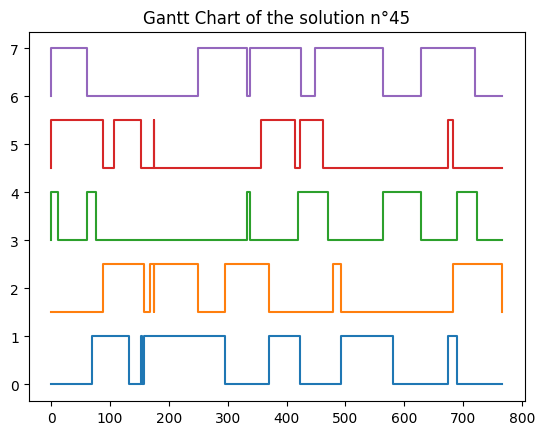

Makespan of the solution n°45 : 766
Regularity of the solution n°45 : 4524
Objective function of the solution n°45 : 3465384


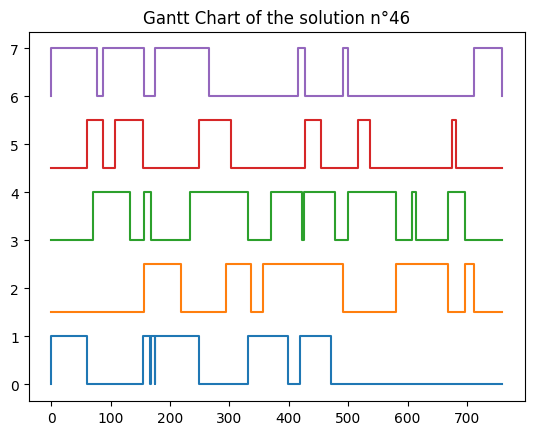

Makespan of the solution n°46 : 759
Regularity of the solution n°46 : 4546
Objective function of the solution n°46 : 3450414


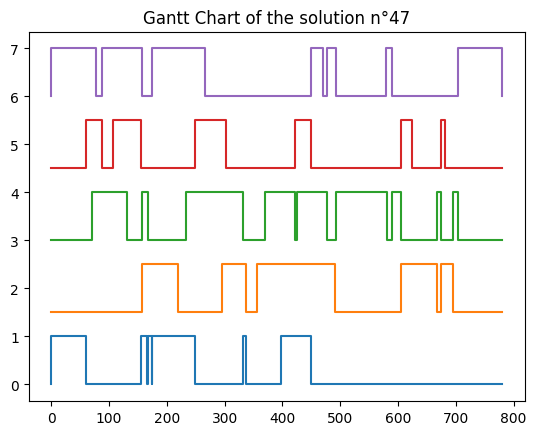

Makespan of the solution n°47 : 780
Regularity of the solution n°47 : 4532
Objective function of the solution n°47 : 3534960


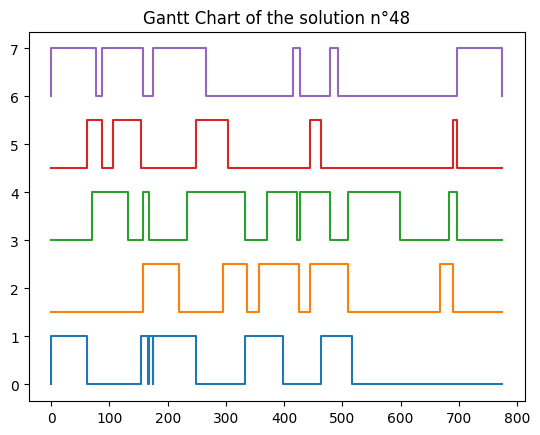

Makespan of the solution n°48 : 774
Regularity of the solution n°48 : 4560
Objective function of the solution n°48 : 3529440


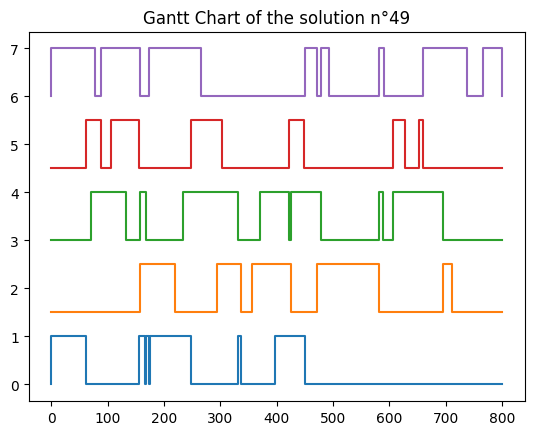

Makespan of the solution n°49 : 800
Regularity of the solution n°49 : 4542
Objective function of the solution n°49 : 3633600


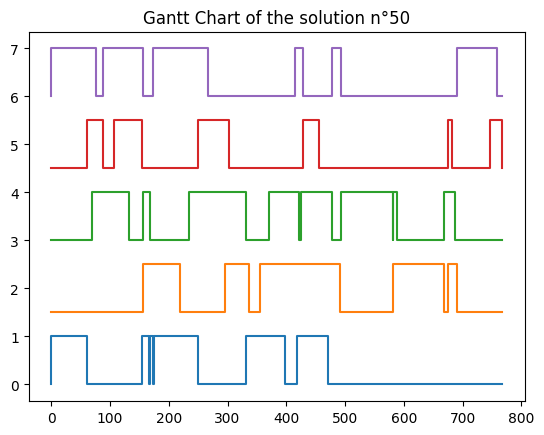

Makespan of the solution n°50 : 767
Regularity of the solution n°50 : 4634
Objective function of the solution n°50 : 3554278


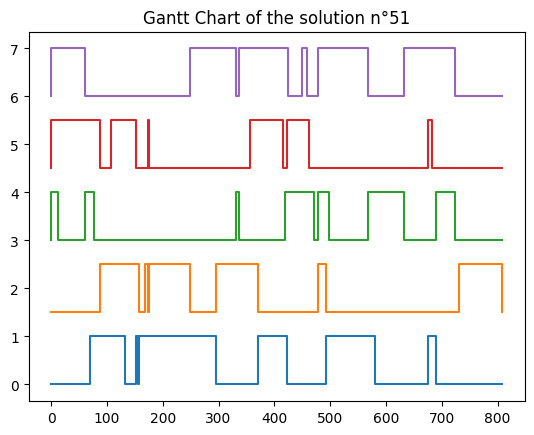

Makespan of the solution n°51 : 808
Regularity of the solution n°51 : 4700
Objective function of the solution n°51 : 3797600


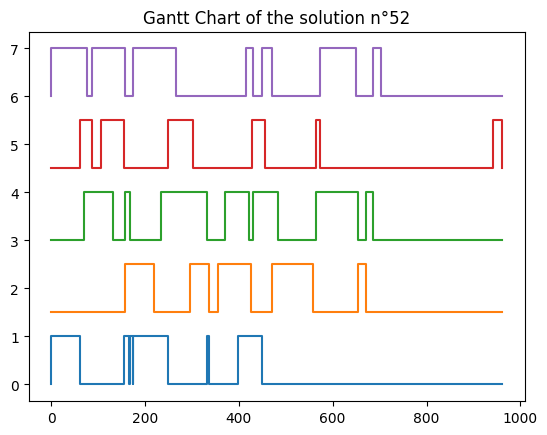

Makespan of the solution n°52 : 961
Regularity of the solution n°52 : 4576
Objective function of the solution n°52 : 4397536


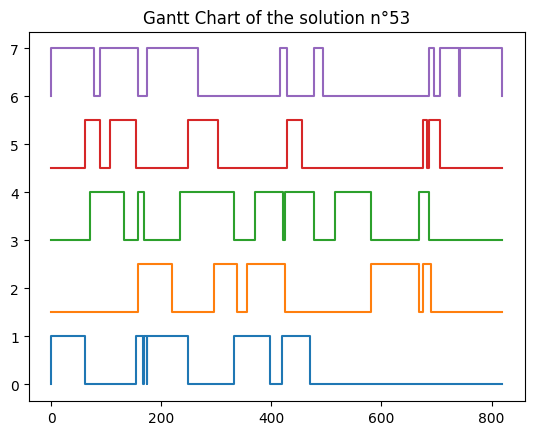

Makespan of the solution n°53 : 819
Regularity of the solution n°53 : 4770
Objective function of the solution n°53 : 3906630


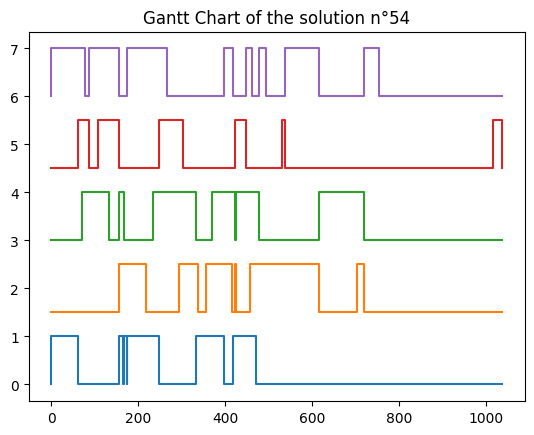

Makespan of the solution n°54 : 1037
Regularity of the solution n°54 : 4680
Objective function of the solution n°54 : 4853160


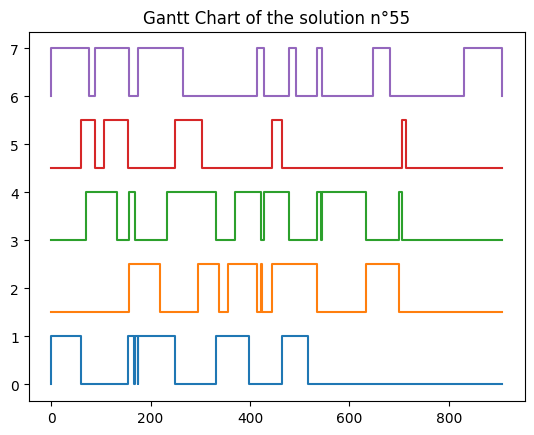

Makespan of the solution n°55 : 907
Regularity of the solution n°55 : 4972
Objective function of the solution n°55 : 4509604


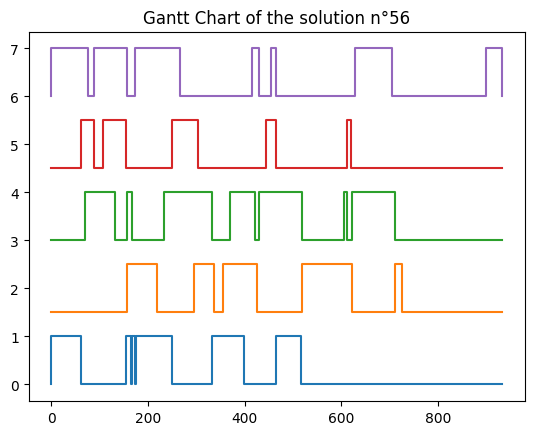

Makespan of the solution n°56 : 932
Regularity of the solution n°56 : 4962
Objective function of the solution n°56 : 4624584


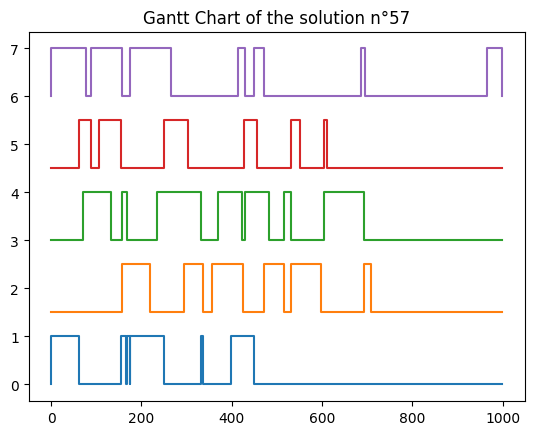

Makespan of the solution n°57 : 999
Regularity of the solution n°57 : 4962
Objective function of the solution n°57 : 4957038


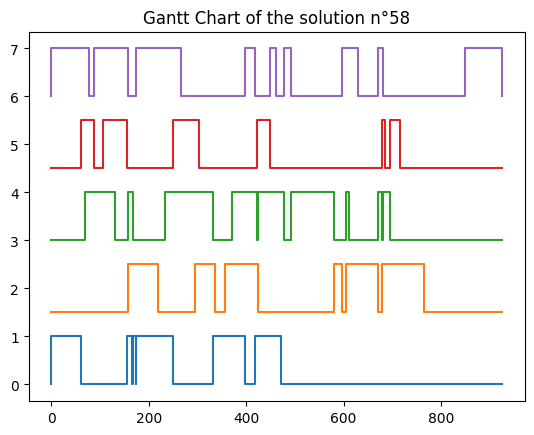

Makespan of the solution n°58 : 925
Regularity of the solution n°58 : 5226
Objective function of the solution n°58 : 4834050


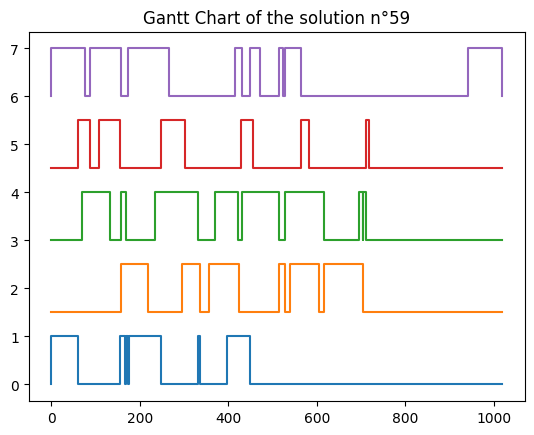

Makespan of the solution n°59 : 1018
Regularity of the solution n°59 : 5162
Objective function of the solution n°59 : 5254916


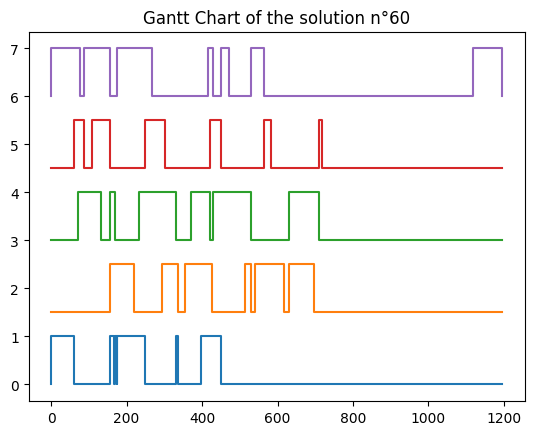

Makespan of the solution n°60 : 1195
Regularity of the solution n°60 : 5856
Objective function of the solution n°60 : 6997920


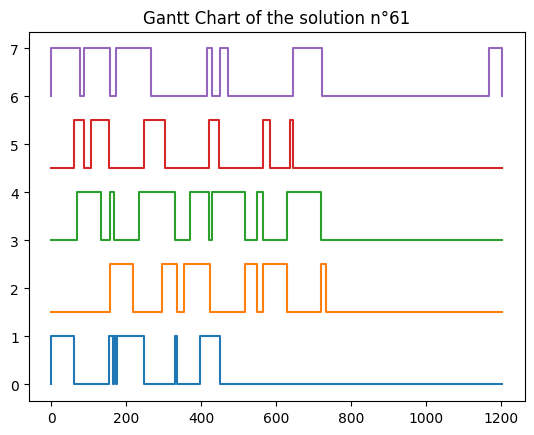

Makespan of the solution n°61 : 1204
Regularity of the solution n°61 : 6166
Objective function of the solution n°61 : 7423864


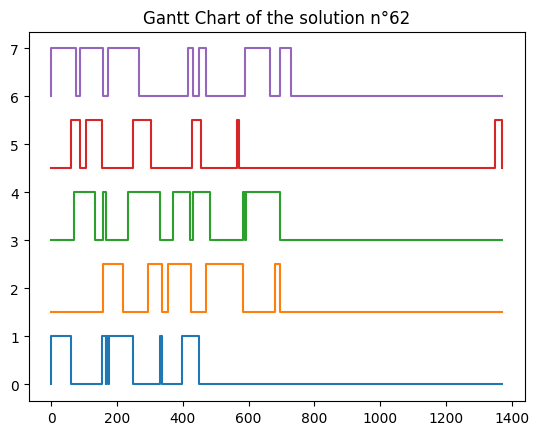

Makespan of the solution n°62 : 1370
Regularity of the solution n°62 : 6168
Objective function of the solution n°62 : 8450160


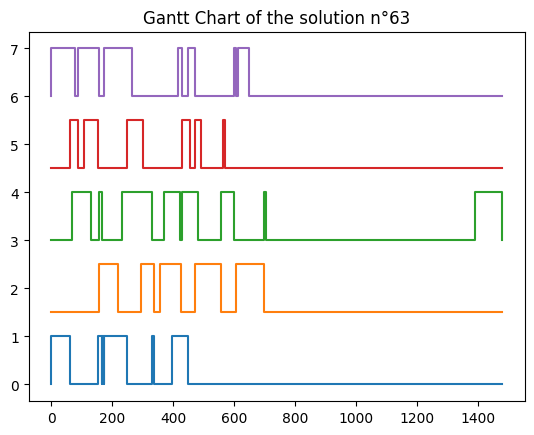

Makespan of the solution n°63 : 1480
Regularity of the solution n°63 : 6406
Objective function of the solution n°63 : 9480880


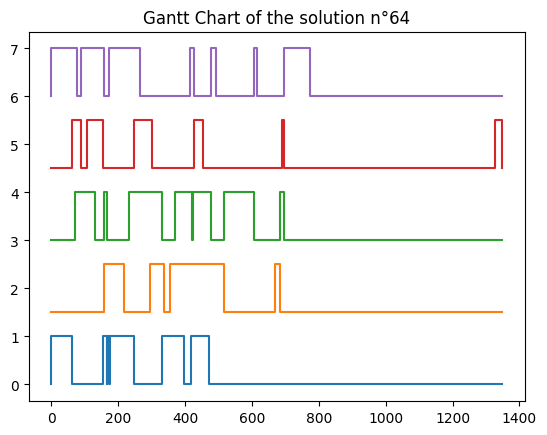

Makespan of the solution n°64 : 1348
Regularity of the solution n°64 : 7078
Objective function of the solution n°64 : 9541144


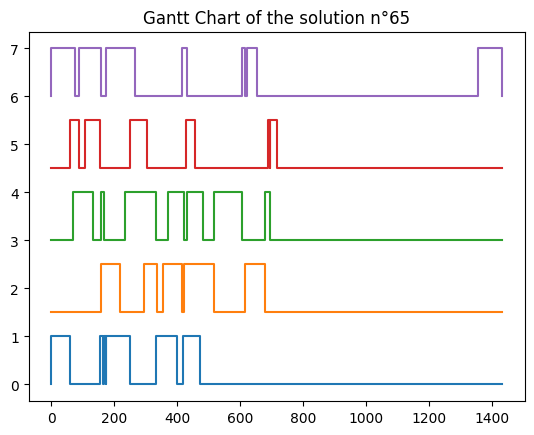

Makespan of the solution n°65 : 1431
Regularity of the solution n°65 : 7122
Objective function of the solution n°65 : 10191582


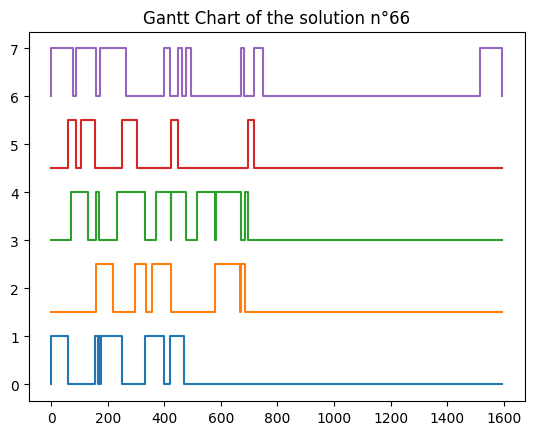

Makespan of the solution n°66 : 1594
Regularity of the solution n°66 : 7964
Objective function of the solution n°66 : 12694616


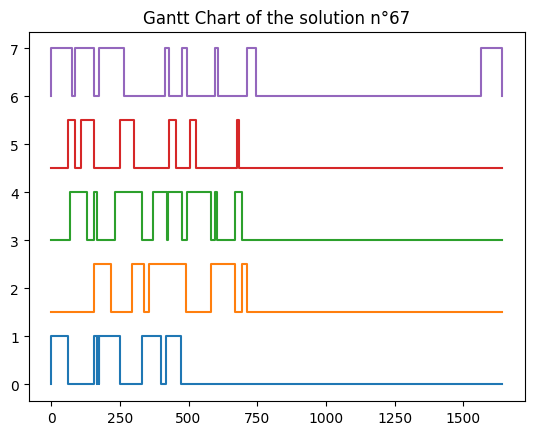

Makespan of the solution n°67 : 1641
Regularity of the solution n°67 : 8074
Objective function of the solution n°67 : 13249434


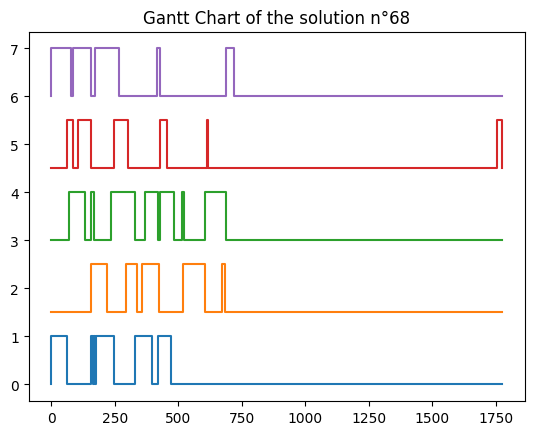

Makespan of the solution n°68 : 1775
Regularity of the solution n°68 : 8114
Objective function of the solution n°68 : 14402350


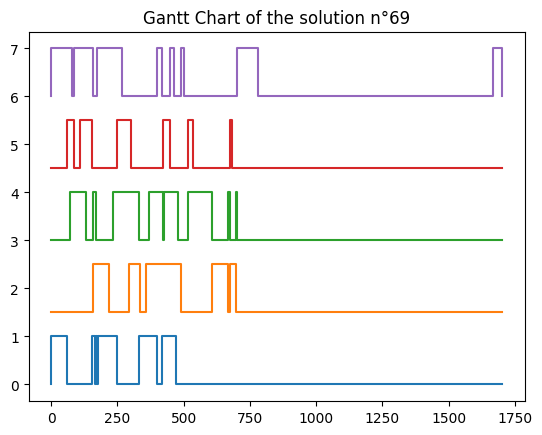

Makespan of the solution n°69 : 1701
Regularity of the solution n°69 : 8440
Objective function of the solution n°69 : 14356440


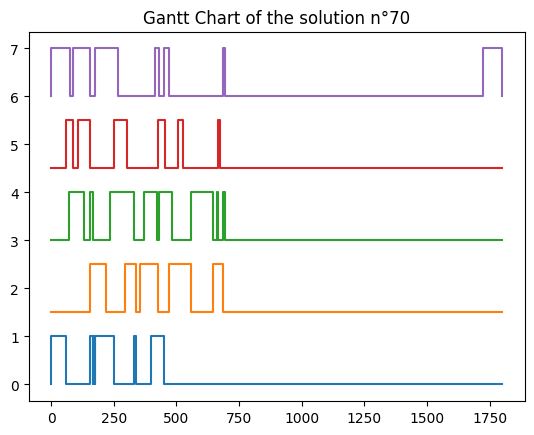

Makespan of the solution n°70 : 1800
Regularity of the solution n°70 : 8412
Objective function of the solution n°70 : 15141600


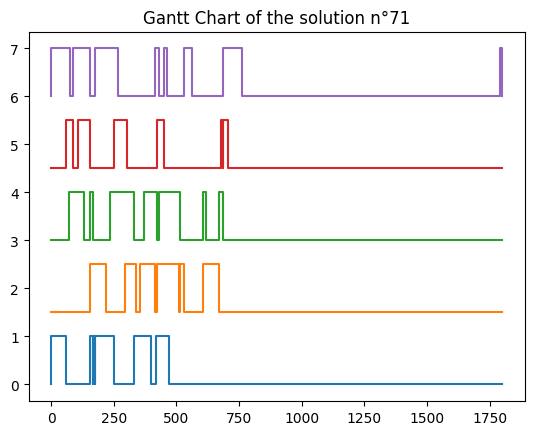

Makespan of the solution n°71 : 1799
Regularity of the solution n°71 : 8560
Objective function of the solution n°71 : 15399440


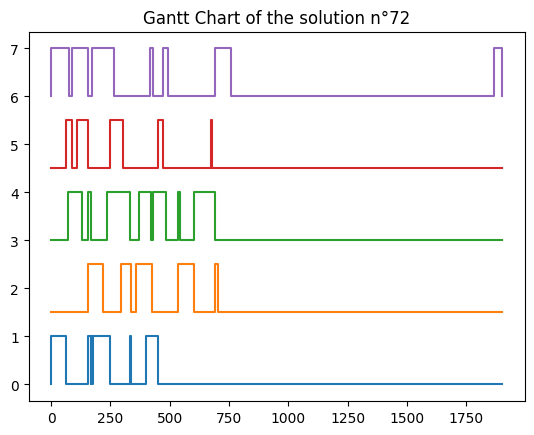

Makespan of the solution n°72 : 1901
Regularity of the solution n°72 : 9152
Objective function of the solution n°72 : 17397952


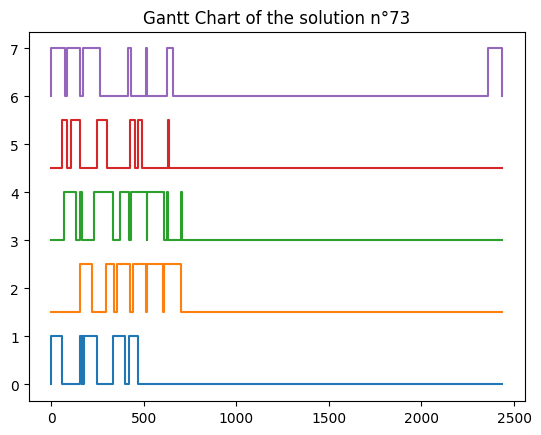

Makespan of the solution n°73 : 2435
Regularity of the solution n°73 : 10606
Objective function of the solution n°73 : 25825610


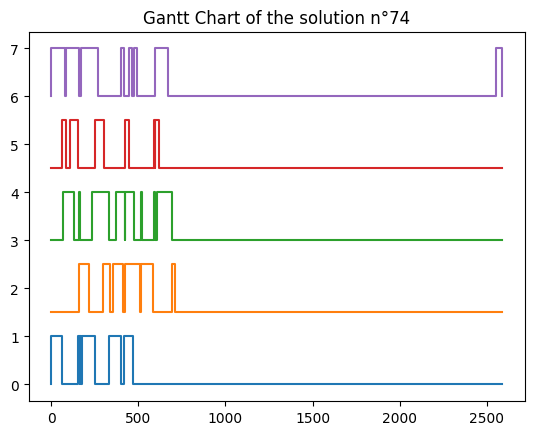

Makespan of the solution n°74 : 2587
Regularity of the solution n°74 : 11220
Objective function of the solution n°74 : 29026140


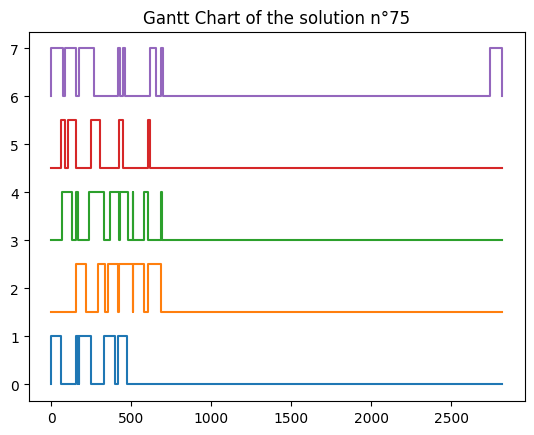

Makespan of the solution n°75 : 2818
Regularity of the solution n°75 : 11998
Objective function of the solution n°75 : 33810364


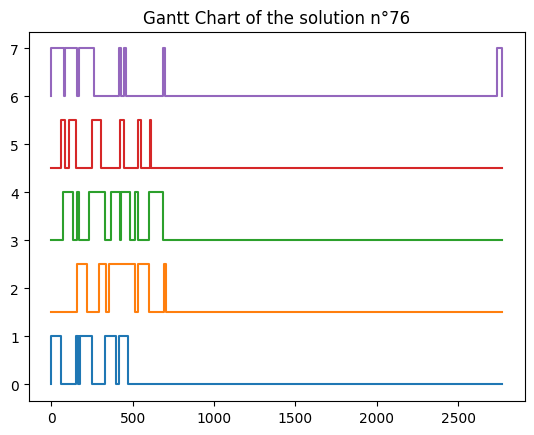

Makespan of the solution n°76 : 2768
Regularity of the solution n°76 : 12100
Objective function of the solution n°76 : 33492800


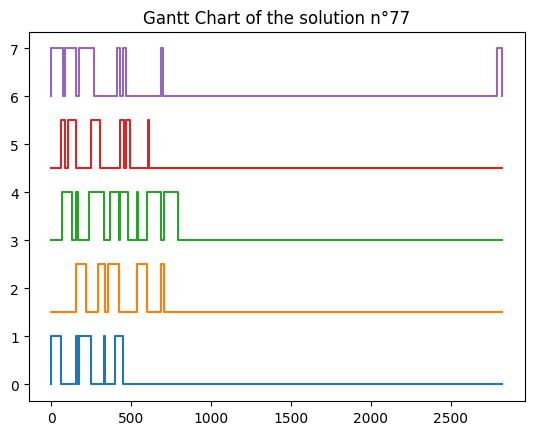

Makespan of the solution n°77 : 2822
Regularity of the solution n°77 : 12452
Objective function of the solution n°77 : 35139544


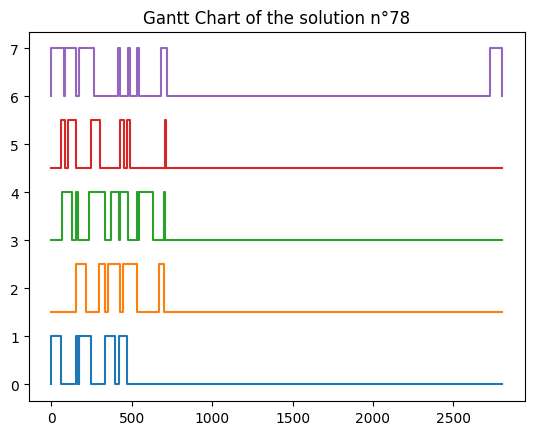

Makespan of the solution n°78 : 2802
Regularity of the solution n°78 : 12736
Objective function of the solution n°78 : 35686272


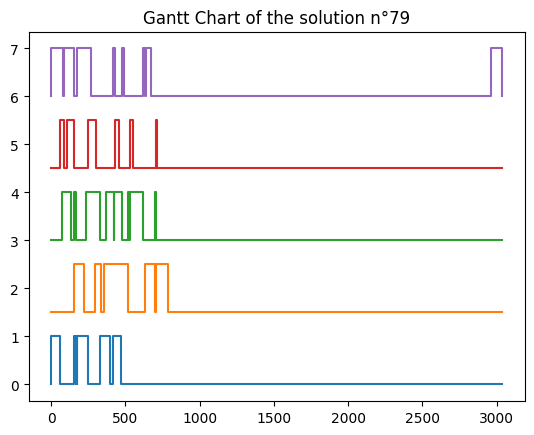

Makespan of the solution n°79 : 3036
Regularity of the solution n°79 : 13570
Objective function of the solution n°79 : 41198520


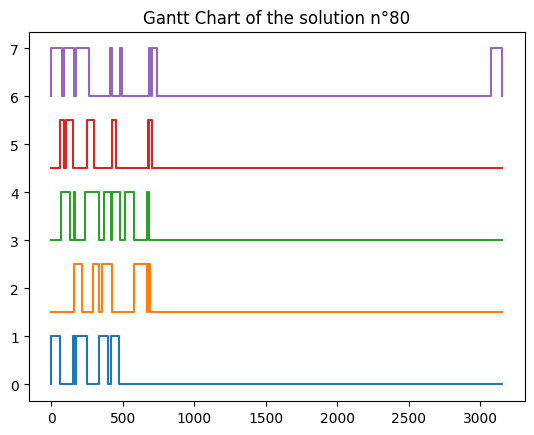

Makespan of the solution n°80 : 3153
Regularity of the solution n°80 : 14106
Objective function of the solution n°80 : 44476218


In [10]:
pref = user.getPreferences()
print(len(pref))

# ------------ Generate Gantt Chart
start_times = []
end_times = []
task_lengths = []

n_sol = 0
for sol in pref:
    n_sol = n_sol + 1
    sol_list = sol.get_all_var_solutions()
    
    mkspan=max([sol_list[i].get_end() for i in range(len(sol_list))] )
    x = [ [] for i in range(m)]
    y = [ [] for i in range(m)]
    mp = [ {} for i in range(m)]
    sz=len(sol_list)
    for i in range(sz) : 
        ind=T_machine[i]
        x[ind].append(sol_list[i].get_start())
        mp[ind][sol_list[i].get_start()]=ind
        x[ind].append(sol_list[i].get_end())
        mp[ind][sol_list[i].get_end()]=ind+1
    eps=0.5
    for i in range(m):
        x[i]=sorted(x[i])
        y[i]=[mp[i][x[i][j]]+i*eps for j in range(len(x[i]))]
        x[i]=[0]+x[i]
        y[i]=[i+i*eps]+y[i]
        x[i]=x[i]+[mkspan]
        y[i].append(i+i*eps)
        plt.step(x[i],y[i])
    plt.title("Gantt Chart of the solution n°" + str(n_sol))
    plt.show()
    print("Makespan of the solution n°" + str(n_sol) + " : " + str(mkspan))
    print("Regularity of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunctionRegularity(sol, n, m)))
    print("Objective function of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m)))